<a href="https://colab.research.google.com/github/Sarthak702-droid/video-sentiment-analysis/blob/main/video_sentiment_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.8 MB/s eta 0:00:00


In [ ]:
import cv2
import pandas as pd
from deepface import DeepFace
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from flask import Flask, request, jsonify, render_template
import pandas as pd

In [ ]:
# List of videos
video_files = ["mahavtars.mp4", "mahavtars1.mp4", "mahavtars2.mp4","mahavtars4.mp4","mahavtars3.mp4"]

# Store both raw emotion data and dominant emotion
results = []

for vid_idx, video_path in enumerate(video_files):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = fps * 1  # 1 frame per second

    frame_no = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_no % frame_interval == 0:
            try:
                # Use a different analysis action to get features, e.g., 'age', 'gender', 'race'
                # or manually get the raw emotion probabilities
                analysis = DeepFace.analyze(
                    frame,
                    actions=['emotion'],
                    enforce_detection=False
                )

                # Get the emotion probability data
                emotions = analysis[0]['emotion']

                # Add the dominant emotion as the target
                emotions['dominant_emotion'] = analysis[0]['dominant_emotion']

                # Add timestamp and video ID for context
                emotions['video_id'] = vid_idx
                emotions['timestamp'] = frame_no / fps

                results.append(emotions)

            except Exception as e:
                # Handle cases where no face is detected
                print(f"No face detected in video {vid_idx}, frame {frame_no}. Error: {e}")

        frame_no += 1
    cap.release()

# Convert results to DataFrame
df = pd.DataFrame(results)

# Now, define X and y correctly
# X will be the emotion probability scores
X = df[[ 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']]

# y will be the dominant emotion
y = df['dominant_emotion']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Your subsequent steps for splitting, training, and evaluation will follow from here.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

25-09-18 04:25:47 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 67.4MB/s]


Features shape: (232, 7)
Target shape: (232,)


LogisticRegression(max_iter=1000)

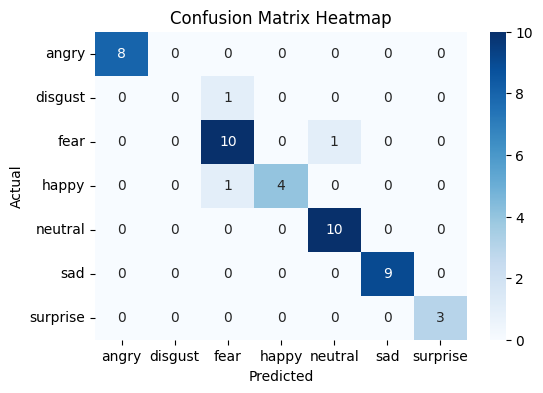

In [ ]:
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9361702127659575
Classification Report:
               precision    recall  f1-score   support

       angry       1.00      1.00      1.00         8
     disgust       0.00      0.00      0.00         1
        fear       0.83      0.91      0.87        11
       happy       1.00      0.80      0.89         5
     neutral       0.91      1.00      0.95        10
         sad       1.00      1.00      1.00         9
    surprise       1.00      1.00      1.00         3

    accuracy                           0.94        47
   macro avg       0.82      0.82      0.82        47
weighted avg       0.92      0.94      0.93        47



In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.6 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

st.set_page_config(page_title="Video Sentiment Analysis", layout="wide")

st.title("🎥 Video Sentiment Analysis")
st.write("Upload a video to analyze the emotions over time.")

uploaded_file = st.file_uploader("Choose a video file...", type=["mp4", "avi", "mov", "mkv", "mpeg4"])

if uploaded_file is not None:
    st.success(f"File uploaded successfully! Analyzing `{uploaded_file.name}` ...")

    # Save the uploaded video
    with open("temp_video.mp4", "wb") as f:
        f.write(uploaded_file.read())

    # Open video
    cap = cv2.VideoCapture("temp_video.mp4")
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    timestamps = []
    emotions = []

    frame_number = 0
    with st.spinner("Analyzing video... please wait ⏳"):
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Analyze every 2 seconds
            if frame_number % (fps * 2) == 0:
                try:
                    analysis = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
                    dominant_emotion = analysis[0]['dominant_emotion']
                    emotions.append(dominant_emotion)
                    timestamps.append(frame_number // fps)
                except Exception as e:
                    emotions.append("Unknown")
                    timestamps.append(frame_number // fps)

            frame_number += 1

    cap.release()

    # Show results
    if emotions:
        st.subheader("📊 Emotion Timeline")

        fig, ax = plt.subplots()
        ax.plot(timestamps, emotions, marker="o", linestyle="--", color="b")
        ax.set_xlabel("Time (seconds)")
        ax.set_ylabel("Detected Emotion")
        ax.set_title("Emotion Change Over Time")
        plt.xticks(rotation=45)

        st.pyplot(fig)

        # Show last detected emotion
        st.info(f"Final detected emotion: **{emotions[-1]}**")
    else:
        st.error("No emotions detected. Try another video or check your setup.")